In [1]:
from pydub import AudioSegment
import numpy as np
import numpy
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
song1 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/Grenade.mp3')
song2 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/If I Die Young.mp3')

In [10]:
print("the first song : ",song1.frame_count(),song1.frame_rate,song1.frame_width,song1.duration_seconds)
print("the scond song : ",song2.frame_count(),song2.frame_rate,song2.frame_width,song2.duration_seconds)

('the first song : ', 11023535.0, 44100, 4, 249.96678004535147)
('the scond song : ', 10945199.0, 44100, 4, 248.19045351473923)


In [25]:
samples1 = song1.get_array_of_samples()
samples2 = song2.get_array_of_samples()
sample1_L = np.asarray([samples1[i] for i in range(0,len(samples1),2)])
print(len(sample1_L))
sample2_L = np.asarray([smaples2[i] for i in range(0,len(samples2),2)])
print(len(sample2_L))

500000
10945199


In [24]:
print("the first song's array length : ",len(samples1)," but extracted : ",len(sample1_L))
print("the second song's array length : ",len(samples2)," but extracted : ",len(sample2_L))

("the first song's array length : ", 22047070, ' but extracted : ', 11023535)
("the second song's array length : ", 21890398, ' but extracted : ', 600000)


In [2]:
def audio2frame(signal,frame_length,frame_step,winfunc=lambda x:numpy.ones((x,))):
    '''将音频信号转化为帧。
	参数含义：
	signal:原始音频型号
	frame_length:每一帧的长度(这里指采样点的长度，即采样频率乘以时间间隔)
	frame_step:相邻帧的间隔（同上定义）
	winfunc:lambda函数，用于生成一个向量
    '''
    signal_length=len(signal) #信号总长度
    print('signal_length : ',signal_length)
    frame_length=int(round(frame_length)) #以帧帧时间长度
    print('frame_length : ',frame_length)
    frame_step=int(round(frame_step)) #相邻帧之间的步长
    print('frame_step : ',frame_step)
    if signal_length<=frame_length: #若信号长度小于一个帧的长度，则帧数定义为1
        frames_num=1
    else: #否则，计算帧的总长度
        frames_num=1+int(math.ceil((1.0*signal_length-frame_length)/frame_step))
    print('frames_num : ',frames_num)
    pad_length=int((frames_num-1)*frame_step+frame_length) #所有帧加起来总的铺平后的长度
    print('pad_length : ',pad_length)
    zeros=numpy.zeros((pad_length-signal_length,)) #不够的长度使用0填补，类似于FFT中的扩充数组操作
    print('zeros shape : ',zeros.shape,'singal shape : ',len(signal))
    pad_signal=numpy.append(signal,zeros) #填补后的信号记为pad_signal
    print('pad_signal shape : ',pad_signal.shape)
    indices=numpy.tile(numpy.arange(0,frame_length),(frames_num,1))+numpy.tile(numpy.arange(0,frames_num*frame_step,frame_step),(frame_length,1)).T  #相当于对所有帧的时间点进行抽取，得到frames_num*frame_length长度的矩阵
    indices=numpy.array(indices,dtype=numpy.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号
    win=numpy.tile(winfunc(frame_length),(frames_num,1))  #window窗函数，这里默认取1
    return frames*win   #返回帧信号矩阵

In [36]:
print(segmented_song1.shape,segmented_song2.shape)

((24989, 4000), (24811, 4000))


In [3]:
def deframesignal(frames,signal_length,frame_length,frame_step,winfunc=lambda x:numpy.ones((x,))):
    '''定义函数对原信号的每一帧进行变换，应该是为了消除关联性
    参数定义：
    frames:audio2frame函数返回的帧矩阵
    signal_length:信号长度
    frame_length:帧长度
    frame_step:帧间隔
    winfunc:对每一帧加window函数进行分析，默认此处不加window
    '''
    #对参数进行取整操作
    signal_length=round(signal_length) #信号的长度
    frame_length=round(frame_length) #帧的长度
    frames_num=numpy.shape(frames)[0] #帧的总数
    assert numpy.shape(frames)[1]==frame_length,'"frames"矩阵大小不正确，它的列数应该等于一帧长度'  #判断frames维度 
    indices=numpy.tile(numpy.arange(0,frame_length),(frames_num,1))+numpy.tile(numpy.arange(0,frames_num*frame_step,frame_step),(frame_length,1)).T  #相当于对所有帧的时间点进行抽取，得到frames_num*frame_length长度的矩阵
    indices=numpy.array(indices,dtype=numpy.int32)
    pad_length=(frames_num-1)*frame_step+frame_length #铺平后的所有信号
    if signal_length<=0:
        signal_length=pad_length
    recalc_signal=numpy.zeros((pad_length,)) #调整后的信号
    window_correction=numpy.zeros((pad_length,1)) #窗关联
    win=winfunc(frame_length)
    for i in range(0,frames_num):
        window_correction[indices[i,:]]=window_correction[indices[i,:]]+win+1e-15 #表示信号的重叠程度
        recalc_signal[indices[i,:]]=recalc_signal[indices[i,:]]+frames[i,:] #原信号加上重叠程度构成调整后的信号
    recalc_signal=recalc_signal/window_correction #新的调整后的信号等于调整信号处以每处的重叠程度 
    return recalc_signal[0:signal_length] #返回该新的调整信号


In [4]:
def spectrum_magnitude(frames,NFFT):
    '''计算每一帧经过FFY变幻以后的频谱的幅度，若frames的大小为N*L,则返回矩阵的大小为N*NFFT
    参数说明：
    frames:即audio2frame函数中的返回值矩阵，帧矩阵
    NFFT:FFT变换的数组大小,如果帧长度小于NFFT，则帧的其余部分用0填充铺满
    '''
    complex_spectrum=numpy.fft.rfft(frames,NFFT) #对frames进行FFT变换
    return numpy.absolute(complex_spectrum)  #返回频谱的幅度值

In [5]:
def spectrum_power(frames,NFFT):
    '''计算每一帧傅立叶变换以后的功率谱
    参数说明：
    frames:audio2frame函数计算出来的帧矩阵
    NFFT:FFT的大小
    '''
    return 1.0/NFFT * numpy.square(spectrum_magnitude(frames,NFFT)) #功率谱等于每一点的幅度平方/NFFT

In [6]:
def log_spectrum_power(frames,NFFT,norm=1):
    '''计算每一帧的功率谱的对数形式
    参数说明：
    frames:帧矩阵，即audio2frame返回的矩阵
    NFFT：FFT变换的大小
    norm:范数，即归一化系数
    '''
    spec_power=spectrum_power(frames,NFFT)
    spec_power[spec_power<1e-30]=1e-30 #为了防止出现功率谱等于0，因为0无法取对数
    log_spec_power=10*numpy.log10(spec_power)
    if norm:
        return log_spec_power-numpy.max(log_spec_power)
    else:
        return log_spec_power



In [7]:
def pre_emphasis(signal,coefficient=0.95):
    '''对信号进行预加重
    参数含义：
    signal:原始信号
    coefficient:加重系数，默认为0.95
    '''
    return numpy.append(signal[0],signal[1:]-coefficient*signal[:-1])

In [8]:
from scipy.fftpack import dct 

In [9]:
def calcMFCC_delta_delta(signal,samplerate=16000,win_length=0.025,win_step=0.01,cep_num=13,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97,cep_lifter=22,appendEnergy=True):
    '''计算13个MFCC+13个一阶微分系数+13个加速系数,一共39个系数
    '''
    feat=calcMFCC(signal,samplerate,win_length,win_step,cep_num,filters_num,NFFT,low_freq,high_freq,pre_emphasis_coeff,cep_lifter,appendEnergy)   #首先获取13个一般MFCC系数
    result1=derivate(feat)
    result2=derivate(result1)
    result3=numpy.concatenate((feat,result1),axis=1)
    result=numpy.concatenate((result3,result2),axis=1)
    return result

In [10]:
def calcMFCC_delta(signal,samplerate=16000,win_length=0.025,win_step=0.01,cep_num=13,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97,cep_lifter=22,appendEnergy=True):
    '''计算13个MFCC+13个一阶微分系数
    '''
    feat=calcMFCC(signal,samplerate,win_length,win_step,cep_num,filters_num,NFFT,low_freq,high_freq,pre_emphasis_coeff,cep_lifter,appendEnergy)   #首先获取13个一般MFCC系数
    result=derivate(feat) #调用derivate函数
    result=numpy.concatenate((feat,result),axis=1)
    return result   

In [12]:
def derivate(feat,big_theta=2,cep_num=13):
    '''计算一阶系数或者加速系数的一般变换公式
    参数说明:
    feat:MFCC数组或者一阶系数数组
    big_theta:公式中的大theta，默认取2
    '''
    result=numpy.zeros(feat.shape) #结果
    denominator=0  #分母
    for theta in numpy.linspace(1,big_theta,big_theta):
        denominator=denominator+theta**2
    denominator=denominator*2 #计算得到分母的值
    for row in numpy.linspace(0,feat.shape[0]-1,feat.shape[0]):
        tmp=numpy.zeros((cep_num,))
        numerator=numpy.zeros((cep_num,)) #分子
        for t in numpy.linspace(1,cep_num,cep_num):
            a=0
            b=0
            s=0
            for theta in numpy.linspace(1,big_theta,big_theta):
                if int(t+theta) < cep_num:
                    a=feat[int(row)][int(t+theta)-1]
                else:
                    a=0
                if (t-theta)<1:
                    b=0
                else:
                    b=feat[int(row)][int(t-theta)-1]
                s+=theta*(a-b)
            numerator[int(t-1)]=s
        tmp=numerator*1.0/denominator
        result[int(row)]=tmp
    return result

In [13]:
def calcMFCC(signal,samplerate=16000,win_length=0.025,win_step=0.01,cep_num=13,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97,cep_lifter=22,appendEnergy=True):
    '''计算13个MFCC系数
    参数含义：
    signal:原始音频信号，一般为.wav格式文件
    samplerate:抽样频率，这里默认为16KHz
    win_length:窗长度，默认即一帧为25ms
    win_step:窗间隔，默认情况下即相邻帧开始时刻之间相隔10ms
    cep_num:倒谱系数的个数，默认为13
    filters_num:滤波器的个数，默认为26
    NFFT:傅立叶变换大小，默认为512
    low_freq:最低频率，默认为0
    high_freq:最高频率
    pre_emphasis_coeff:预加重系数，默认为0.97
    cep_lifter:倒谱的升个数？？
    appendEnergy:是否加上能量，默认加
    '''
    
    feat,energy=fbank(signal,samplerate,win_length,win_step,filters_num,NFFT,low_freq,high_freq,pre_emphasis_coeff)
    feat=numpy.log(feat)
    feat=dct(feat,type=2,axis=1,norm='ortho')[:,:cep_num]  #进行离散余弦变换,只取前13个系数
    feat=lifter(feat,cep_lifter)
    if appendEnergy:
		feat[:,0]=numpy.log(energy)  #只取2-13个系数，第一个用能量的对数来代替
    return feat

In [14]:
def fbank(signal,samplerate=16000,win_length=0.025,win_step=0.01,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97):
    '''计算音频信号的MFCC
    参数说明：
    samplerate:采样频率
    win_length:窗长度
    win_step:窗间隔
    filters_num:梅尔滤波器个数
    NFFT:FFT大小
    low_freq:最低频率
    high_freq:最高频率
    pre_emphasis_coeff:预加重系数
    '''
    
    high_freq=high_freq or samplerate/2  #计算音频样本的最大频率
    signal=pre_emphasis(signal,pre_emphasis_coeff)  #对原始信号进行预加重处理
    frames=audio2frame(signal,win_length*samplerate,win_step*samplerate) #得到帧数组
    spec_power=spectrum_power(frames,NFFT)  #得到每一帧FFT以后的能量谱
    energy=numpy.sum(spec_power,1)  #对每一帧的能量谱进行求和
    energy=numpy.where(energy==0,numpy.finfo(float).eps,energy)  #对能量为0的地方调整为eps，这样便于进行对数处理
    fb=get_filter_banks(filters_num,NFFT,samplerate,low_freq,high_freq)  #获得每一个滤波器的频率宽度
    feat=numpy.dot(spec_power,fb.T)  #对滤波器和能量谱进行点乘
    feat=numpy.where(feat==0,numpy.finfo(float).eps,feat)  #同样不能出现0
    return feat,energy

In [15]:
def log_fbank(signal,samplerate=16000,win_length=0.025,win_step=0.01,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97):
    '''计算对数值
    参数含义：同上
    '''
    feat,energy=fbank(signal,samplerate,win_length,win_step,filters_num,NFFT,low_freq,high_freq,pre_emphasis_coeff)
    return numpy.log(feat)

In [16]:
def ssc(signal,samplerate=16000,win_length=0.025,win_step=0.01,filters_num=26,NFFT=512,low_freq=0,high_freq=None,pre_emphasis_coeff=0.97):
    '''
    待补充
    ''' 
    high_freq=high_freq or samplerate/2
    signal=sigprocess.pre_emphasis(signal,pre_emphasis_coeff)
    frames=sigprocess.audio2frame(signal,win_length*samplerate,win_step*samplerate)
    spec_power=sigprocess.spectrum_power(frames,NFFT) 
    spec_power=numpy.where(spec_power==0,numpy.finfo(float).eps,spec_power) #能量谱
    fb=get_filter_banks(filters_num,NFFT,samplerate,low_freq,high_freq) 
    feat=numpy.dot(spec_power,fb.T)  #计算能量
    R=numpy.tile(numpy.linspace(1,samplerate/2,numpy.size(spec_power,1)),(numpy.size(spec_power,0),1))
    return numpy.dot(spec_power*R,fb.T)/feat

In [17]:
def hz2mel(hz):
    '''把频率hz转化为梅尔频率
    参数说明：
    hz:频率
    '''
    return 2595*numpy.log10(1+hz/700.0)

def mel2hz(mel):
    '''把梅尔频率转化为hz
    参数说明：
    mel:梅尔频率
    '''
    return 700*(10**(mel/2595.0)-1)

In [18]:
def get_filter_banks(filters_num=20,NFFT=512,samplerate=16000,low_freq=0,high_freq=None):
    '''计算梅尔三角间距滤波器，该滤波器在第一个频率和第三个频率处为0，在第二个频率处为1
    参数说明：
    filers_num:滤波器个数
    NFFT:FFT大小
    samplerate:采样频率
    low_freq:最低频率
    high_freq:最高频率
    '''
    #首先，将频率hz转化为梅尔频率，因为人耳分辨声音的大小与频率并非线性正比，所以化为梅尔频率再线性分隔
    low_mel=hz2mel(low_freq)
    high_mel=hz2mel(high_freq)
    #需要在low_mel和high_mel之间等间距插入filters_num个点，一共filters_num+2个点
    mel_points=numpy.linspace(low_mel,high_mel,filters_num+2)
    #再将梅尔频率转化为hz频率，并且找到对应的hz位置
    hz_points=mel2hz(mel_points)
    #我们现在需要知道这些hz_points对应到fft中的位置
    bin=numpy.floor((NFFT+1)*hz_points/samplerate)
    #接下来建立滤波器的表达式了，每个滤波器在第一个点处和第三个点处均为0，中间为三角形形状
    fbank=numpy.zeros([filters_num,NFFT/2+1])
    for j in xrange(0,filters_num):
	for i in xrange(int(bin[j]),int(bin[j+1])):
	    fbank[j,i]=(i-bin[j])/(bin[j+1]-bin[j])
	for i in xrange(int(bin[j+1]),int(bin[j+2])):
	    fbank[j,i]=(bin[j+2]-i)/(bin[j+2]-bin[j+1])
    return fbank

In [19]:
def lifter(cepstra,L=22):
    '''升倒谱函数
    参数说明：
    cepstra:MFCC系数
    L：升系数，默认为22
    '''
    if L>0:
	nframes,ncoeff=numpy.shape(cepstra)
	n=numpy.arange(ncoeff)
	lift=1+(L/2)*numpy.sin(numpy.pi*n/L)
	return lift*cepstra
    else:
	return cepstra

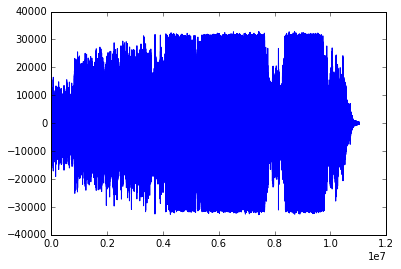

In [23]:
plt.plot(sample1_L)

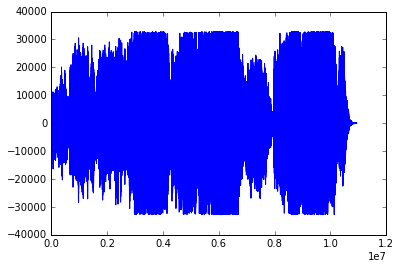

In [26]:
plt.plot(sample2_L)

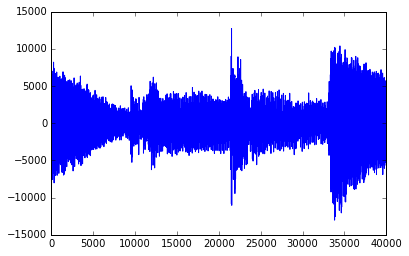

In [64]:
plt.plot(sample1_L[200000:240000])

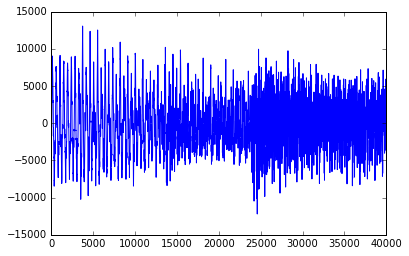

In [65]:
plt.plot(sample2_L[200000:240000])

In [66]:
#  对部分原始信号进行预加重处理
pre_emphasised_song1 = pre_emphasis(sample1_L[200000:240000],0.97)
pre_emphasised_song2 = pre_emphasis(sample2_L[200000:240000],0.97)

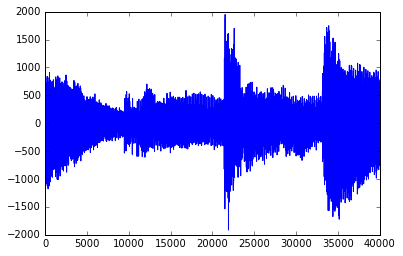

In [67]:
plt.plot(pre_emphasised_song1)

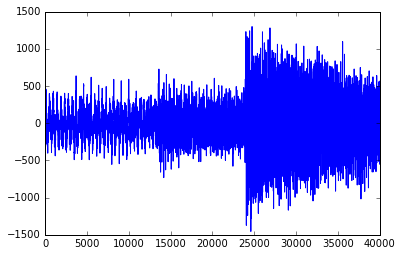

In [68]:
plt.plot(pre_emphasised_song2)

In [72]:
#   时间窗长度 25ms，时间窗间隔 1ms
segmented_song1 = audio2frame(pre_emphasised_song1,song1.frame_rate*0.025,song1.frame_rate*0.001)
print('===============================')
segmented_song2 = audio2frame(pre_emphasised_song2,song1.frame_rate*0.025,song1.frame_rate*0.001)

('signal_length : ', 40000)
('frame_length : ', 1103)
('frame_step : ', 44)
('frames_num : ', 886)
('pad_length : ', 40043)
('zeros shape : ', (43,), 'singal shape : ', 40000)
('pad_signal shape : ', (40043,))
('signal_length : ', 40000)
('frame_length : ', 1103)
('frame_step : ', 44)
('frames_num : ', 886)
('pad_length : ', 40043)
('zeros shape : ', (43,), 'singal shape : ', 40000)
('pad_signal shape : ', (40043,))


In [73]:
print(segmented_song1.shape,segmented_song2.shape)

((886, 1103), (886, 1103))


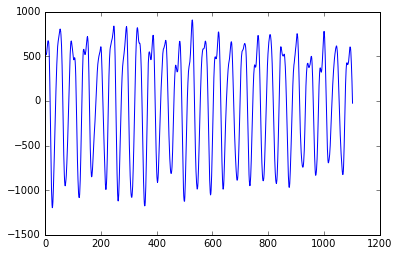

In [77]:
plt.plot(segmented_song1[0])

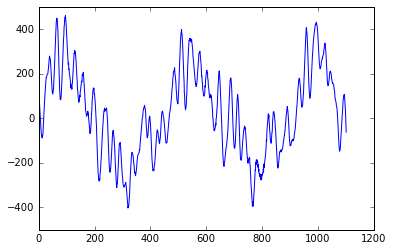

In [78]:
plt.plot(segmented_song2[0])

In [79]:
#  512 为傅立叶变换大小
#  计算每一帧傅立叶变换以后的功率谱
spec_power_song1 = spectrum_power(segmented_song1,512)
spec_power_song2 = spectrum_power(segmented_song2,512)
print(spec_power_song1.shape,spec_power_song2.shape)

((886, 257), (886, 257))


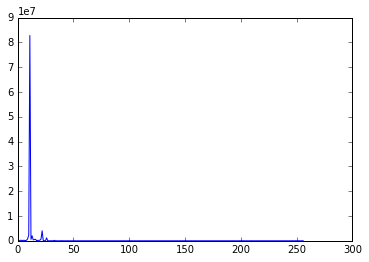

In [80]:
plt.plot(spec_power_song1[0])

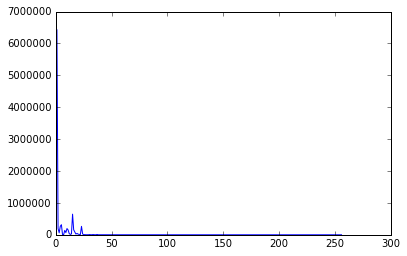

In [81]:
plt.plot(spec_power_song2[0])

In [84]:
#对每一帧的能量谱进行求和
energy_song1 = numpy.sum(spec_power_song1,1)
energy_song2 = numpy.sum(spec_power_song2,1)

#对能量为0的地方调整为eps，这样便于进行对数处理
energy_song1 = numpy.where(energy_song1==0,numpy.finfo(float).eps,energy_song1)
energy_song2 = numpy.where(energy_song2==0,numpy.finfo(float).eps,energy_song2)
print(energy_song1.shape,energy_song2.shape)
print(energy_song1[:10])
print(energy_song2[:10])

((886,), (886,))
[ 99368201.44011664  98179769.12623224  97496210.69540353
  96274902.69579102  93822223.00675096  95090376.34535721
  91607540.00050159  91419632.59517851  88968675.81108943
  86729573.05556583]
[  9430859.06523126  10641870.2709424   10008631.83294552
   8240994.66431739   8251782.50828517   8147562.17617071
   9000116.63703009   9032305.86599786   7472897.33750411
   7493439.67142442]


In [96]:
# 获得每一个滤波器的频率宽度
fb_song1 = get_filter_banks(26,512,song1.frame_rate,0,song1.frame_rate/2)
fb_song2 = get_filter_banks(26,512,song2.frame_rate,0,song2.frame_rate/2)
print(fb_song1.shape,fb_song2.shape)

((26, 257), (26, 257))


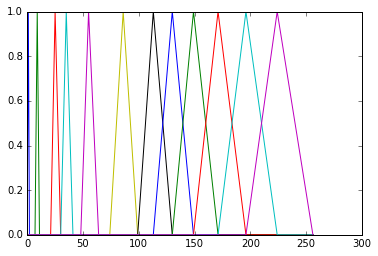

In [97]:
f = plt.plot(numpy.arange(257),fb_song1[0],numpy.arange(257),fb_song1[5],
         numpy.arange(257),fb_song1[10],numpy.arange(257),fb_song1[12],
         numpy.arange(257),fb_song1[15],numpy.arange(257),fb_song1[18],
        numpy.arange(257),fb_song1[20],numpy.arange(257),fb_song1[21],
        numpy.arange(257),fb_song1[22],numpy.arange(257),fb_song1[23],
        numpy.arange(257),fb_song1[24],numpy.arange(257),fb_song1[25])

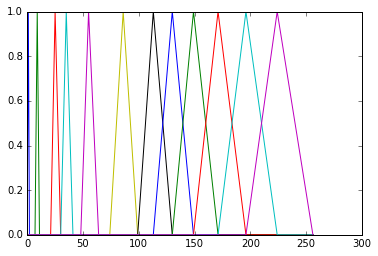

In [98]:
f = plt.plot(numpy.arange(257),fb_song2[0],numpy.arange(257),fb_song2[5],
         numpy.arange(257),fb_song2[10],numpy.arange(257),fb_song2[12],
         numpy.arange(257),fb_song2[15],numpy.arange(257),fb_song2[18],
        numpy.arange(257),fb_song2[20],numpy.arange(257),fb_song2[21],
        numpy.arange(257),fb_song2[22],numpy.arange(257),fb_song2[23],
        numpy.arange(257),fb_song2[24],numpy.arange(257),fb_song2[25])

In [99]:
# 对滤波器和能量谱进行点乘
feat_song1 = numpy.dot(spec_power_song1,fb_song1.T)
feat_song2 = numpy.dot(spec_power_song2,fb_song2.T)
feat_song1=numpy.where(feat_song1==0,numpy.finfo(float).eps,feat_song1)
feat_song2=numpy.where(feat_song2==0,numpy.finfo(float).eps,feat_song2)
print(feat_song1.shape,feat_song2.shape)

((886, 26), (886, 26))


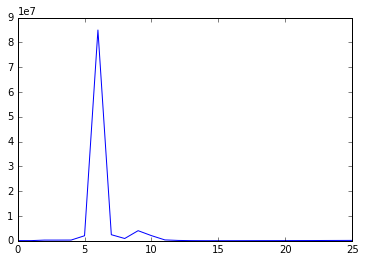

In [101]:
plt.plot(feat_song1[0])

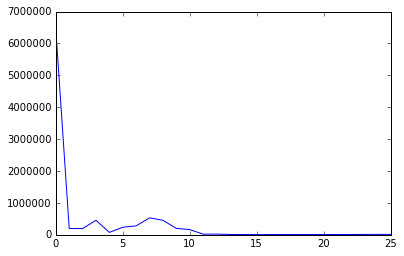

In [102]:
plt.plot(feat_song2[0])

In [103]:
log_feat_song1 = numpy.log(feat_song1)
log_feat_song2 = numpy.log(feat_song2)

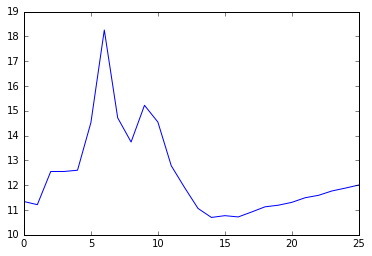

In [104]:
plt.plot(log_feat_song1[0])

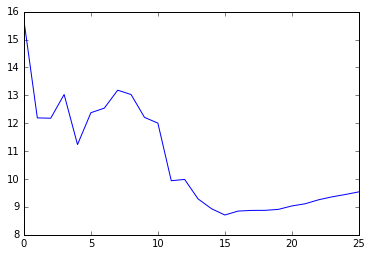

In [105]:
plt.plot(log_feat_song2[0])

In [106]:
#进行离散余弦变换,只取前13个系数
dct_feat_song1 = dct(log_feat_song1,type=2,axis=1,norm='ortho')[:,:13]
dct_feat_song2 = dct(log_feat_song2,type=2,axis=1,norm='ortho')[:,:13]
print(dct_feat_song1.shape,dct_feat_song2.shape)

((886, 13), (886, 13))


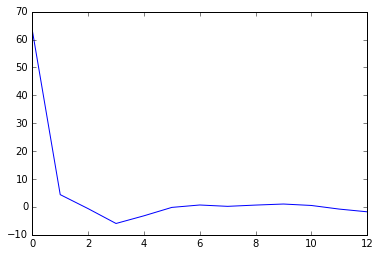

In [107]:
plt.plot(dct_feat_song1[0])

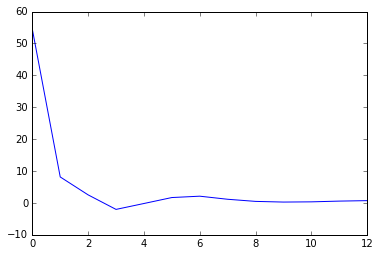

In [108]:
plt.plot(dct_feat_song2[0])

In [111]:
lifted_feat_song1=lifter(dct_feat_song1,22)
lifted_feat_song2=lifter(dct_feat_song2,22)
print(lifted_feat_song1.shape,lifted_feat_song2.shape)

((886, 13), (886, 13))


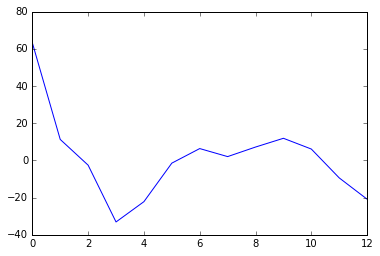

In [112]:
plt.plot(lifted_feat_song1[0])

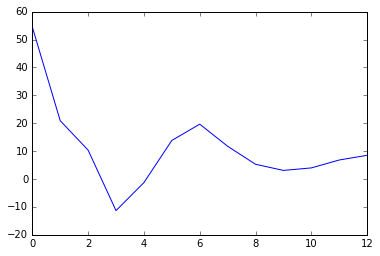

In [113]:
plt.plot(lifted_feat_song2[0])

In [117]:
result1_song1 = derivate(lifted_feat_song1)
result1_song2 = derivate(lifted_feat_song2)
print(result1_song1.shape,result1_song2.shape)

((886, 13), (886, 13))


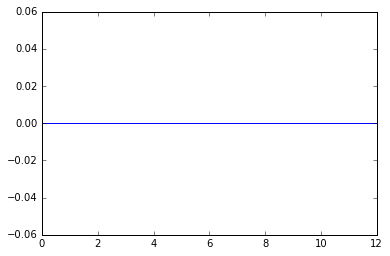

In [126]:
plt.plot(result1_song1[400])

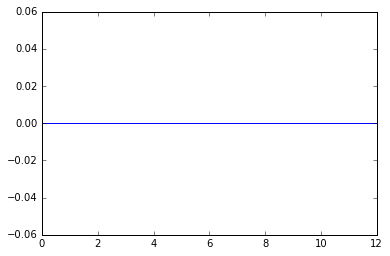

In [127]:
plt.plot(result1_song2[400])

In [122]:
result2_song1 = derivate(result1_song1)
result2_song2 = derivate(result1_song2)
print(result2_song1.shape,result2_song2.shape)

((886, 13), (886, 13))


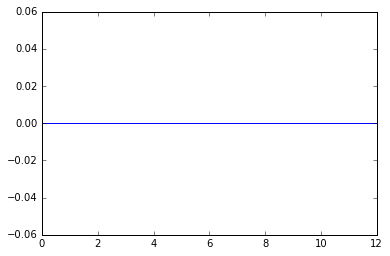

In [123]:
plt.plot(result2_song1[0])

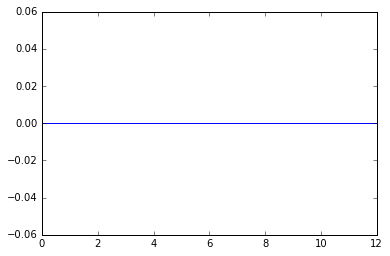

In [124]:
plt.plot(result2_song2[0])

In [20]:
song1 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/Grenade.mp3')
song2 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/If I Die Young.mp3')
song3 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/It Girl.mp3')
song4 = AudioSegment.from_mp3('/Users/heguangqin/Music/xiangmu/为你我受冷风吹.mp3')

In [21]:
smaples1 = song1.get_array_of_samples()
smaples2 = song2.get_array_of_samples()
smaples3 = song3.get_array_of_samples()
smaples4 = song4.get_array_of_samples()

sample1_L = np.asarray([smaples1[i] for i in range(len(smaples1)-2000000,len(smaples1)-1000000,2)])
print(len(sample1_L))
sample2_L = np.asarray([smaples2[i] for i in range(len(smaples2)-2200000,len(smaples2)-1000000,2)])
print(len(sample2_L))
sample3_L = np.asarray([smaples3[i] for i in range(len(smaples3)-2400000,len(smaples3)-1300000,2)])
print(len(sample3_L))
sample4_L = np.asarray([smaples4[i] for i in range(len(smaples4)-2200000,len(smaples4)-1000000,2)])
print(len(sample4_L))

del smaples1,smaples2,smaples3,smaples4

500000
600000
550000
600000


In [22]:
mfcc_feat_for_song1 = calcMFCC_delta_delta(sample1_L, song1.frame_rate)
print(mfcc_feat_for_song1.shape)
print(mfcc_feat_for_song1[:2,:])

('signal_length : ', 500000)
('frame_length : ', 1103)
('frame_step : ', 441)
('frames_num : ', 1133)
('pad_length : ', 500315)
('zeros shape : ', (315,), 'singal shape : ', 500000)
('pad_signal shape : ', (500315,))
(1133, 39)
[[  1.80847214e+01   6.01947007e+00  -2.69504977e-01   5.49047299e+00
   -1.02091019e+01   4.10025319e+00  -1.74264513e+01  -2.70787190e+01
   -8.25653848e+00  -5.97014151e+00  -1.35582806e+01  -1.04544792e+01
   -1.12340587e+01   5.48046012e-01  -7.37328039e-01  -5.71166437e+00
   -1.37780307e+00  -3.57041124e+00  -7.23557333e+00  -2.72738453e+00
   -1.09708766e+00   2.88449189e+00   2.79467375e+00   1.20287393e+00
    2.54985636e+00   3.75710404e+00  -1.21606568e+00  -9.01531653e-01
   -8.87738954e-01  -1.08552375e+00   1.10789430e-02   1.40445754e-01
    1.90482919e+00   2.56723706e+00   1.17522783e+00   5.61227008e-01
   -6.01380116e-01  -6.79222142e-01  -4.95560421e-01]
 [  1.80511356e+01   1.08466080e+01  -8.63925693e+00   1.04212888e+01
   -2.32868166e+01

In [23]:
mfcc_feat_for_song2 = calcMFCC_delta_delta(sample2_L, song2.frame_rate)
print(mfcc_feat_for_song2.shape)

('signal_length : ', 600000)
('frame_length : ', 1103)
('frame_step : ', 441)
('frames_num : ', 1360)
('pad_length : ', 600422)
('zeros shape : ', (422,), 'singal shape : ', 600000)
('pad_signal shape : ', (600422,))
(1360, 39)


In [24]:
mfcc_feat_for_song3 = calcMFCC_delta_delta(sample3_L, song3.frame_rate)
print(mfcc_feat_for_song3.shape)

('signal_length : ', 550000)
('frame_length : ', 1103)
('frame_step : ', 441)
('frames_num : ', 1246)
('pad_length : ', 550148)
('zeros shape : ', (148,), 'singal shape : ', 550000)
('pad_signal shape : ', (550148,))
(1246, 39)


In [25]:
mfcc_feat_for_song4 = calcMFCC_delta_delta(sample4_L, song4.frame_rate)
print(mfcc_feat_for_song4.shape)

('signal_length : ', 600000)
('frame_length : ', 1103)
('frame_step : ', 441)
('frames_num : ', 1360)
('pad_length : ', 600422)
('zeros shape : ', (422,), 'singal shape : ', 600000)
('pad_signal shape : ', (600422,))
(1360, 39)


In [26]:
sample_L_for_test = np.asarray([sample2_L[i] for i in range(len(sample2_L)-400000,len(sample2_L)-200000)])
print(sample_L_for_test.shape)
mfcc_feat_for_test = calcMFCC_delta_delta(sample_L_for_test, song2.frame_rate)
print(mfcc_feat_for_test.shape)

(200000,)
('signal_length : ', 200000)
('frame_length : ', 1103)
('frame_step : ', 441)
('frames_num : ', 453)
('pad_length : ', 200435)
('zeros shape : ', (435,), 'singal shape : ', 200000)
('pad_signal shape : ', (200435,))
(453, 39)


In [28]:
# 计算待匹配音乐与第一首音乐的余弦相似度
sim1 = np.dot(mfcc_feat_for_song1,mfcc_feat_for_test.T)/np.outer(np.sqrt(np.sum(mfcc_feat_for_song1**2,axis=1)),
                                                      np.sqrt(np.sum(mfcc_feat_for_test**2,axis=1)))

sim2 = np.dot(mfcc_feat_for_song2,mfcc_feat_for_test.T)/np.outer(np.sqrt(np.sum(mfcc_feat_for_song2**2,axis=1)),
                                                      np.sqrt(np.sum(mfcc_feat_for_test**2,axis=1)))

sim3 = np.dot(mfcc_feat_for_song3,mfcc_feat_for_test.T)/np.outer(np.sqrt(np.sum(mfcc_feat_for_song3**2,axis=1)),
                                                      np.sqrt(np.sum(mfcc_feat_for_test**2,axis=1)))

sim4 = np.dot(mfcc_feat_for_song4,mfcc_feat_for_test.T)/np.outer(np.sqrt(np.sum(mfcc_feat_for_song4**2,axis=1)),
                                                      np.sqrt(np.sum(mfcc_feat_for_test**2,axis=1)))
print(sim1.shape,sim2.shape,sim3.shape,sim4.shape)

((1133, 453), (1360, 453), (1246, 453), (1360, 453))


In [29]:
song1_inds = np.argmax(sim1,axis=0)
song2_inds = np.argmax(sim2,axis=0)
song3_inds = np.argmax(sim3,axis=0)
song4_inds = np.argmax(sim4,axis=0)
print(song1_inds[100:120])
print(song2_inds[100:120])
print(song3_inds[100:120])
print(song4_inds[100:120])

[436  75 437  74 336  74 743 950 950 956 503 503 968 503 503 503 503 503
 503 503]
[553 554 554 554 558 559 559 561 558 563 563 563 566 567 567 567 567 571
 567 573]
[ 850  866  360  360  729   27  760 1007   71  721  721  721  906  449 1037
  449  847  847  449 1039]
[ 42  91  91  91  90  91  91  87  91 776 772 772  93  84  84 772  84 772
  84 772]


In [53]:
print(sim1[song1_inds,np.arange(mfcc_feat_for_test.shape[0])][200:240])
print(sim2[song2_inds,np.arange(mfcc_feat_for_test.shape[0])][200:240])
print(sim3[song3_inds,np.arange(mfcc_feat_for_test.shape[0])][200:240])
print(sim4[song4_inds,np.arange(mfcc_feat_for_test.shape[0])][200:240])

[ 0.6863467   0.7588668   0.7009244   0.82336847  0.76845767  0.82162631
  0.73087871  0.85854694  0.88998162  0.81027322  0.77814735  0.83245118
  0.87160473  0.8078428   0.82350479  0.86646178  0.8596771   0.81516008
  0.8382492   0.86010894  0.8698353   0.88398613  0.91661368  0.92935339
  0.90604193  0.89678198  0.90148472  0.86893544  0.88224019  0.93988142
  0.93989149  0.9183942   0.91211833  0.93085281  0.93618443  0.95892468
  0.90089644  0.9351527   0.91726443  0.88476224]
[ 0.9715385   0.98517861  0.98755965  0.9897928   0.98299603  0.97849747
  0.94435143  0.97572145  0.98965431  0.98400318  0.9836749   0.9805703
  0.97872501  0.97138457  0.98610194  0.97785421  0.93662677  0.97161253
  0.96195084  0.97384101  0.95406982  0.98560013  0.94796125  0.98104864
  0.98636899  0.98031999  0.96304839  0.99056083  0.97818533  0.97562922
  0.98356014  0.98075019  0.98399055  0.96105136  0.94388394  0.97880283
  0.95710394  0.97483052  0.95208883  0.97434911]
[ 0.87241874  0.83651162 

In [30]:
sim1_value = np.sum(sim1[song1_inds,np.arange(mfcc_feat_for_test.shape[0])])
sim1_value = np.sum(sim2[song2_inds,np.arange(mfcc_feat_for_test.shape[0])])
sim1_value = np.sum(sim3[song3_inds,np.arange(mfcc_feat_for_test.shape[0])])
sim4_value = np.sum(sim4[song4_inds,np.arange(mfcc_feat_for_test.shape[0])])

print(sim1_value,sim1_value,sim1_value,sim4_value)

(405.87475738262367, 405.87475738262367, 405.87475738262367, 340.64444825549873)


In [33]:
np.diff(song1_inds).sum()

1006

In [34]:
np.diff(song2_inds).sum()

440

In [35]:
np.diff(song3_inds).sum()

51

In [36]:
np.diff(song4_inds).sum()

-13

In [45]:
np.diff(song2_inds)[200:240]

array([ 9, -1,  1,  1,  2, -2,  4,  0,  2,  0,  1,  2,  0,  1,  2,  0,  2,
        0,  1,  1,  1, -1,  4, -1,  7, -2, -3,  3,  7, -2,  0, -3,  1,  3,
        2, -2,  1,  3,  1,  2])

In [46]:
np.diff(song1_inds)[200:240]

array([  77, -443,    0,    0,  450,  -84,   84, -450,  447,  429, -876,
          0,  450,  -84,    0, -366,  443,  -58, -349,  348,  538, -538,
        538,    0,  -17,   17, -369,  369, -886,  517,  352, -352, -517,
        908, -393,    2,    0,  391, -559,  -35])

In [47]:
np.diff(song3_inds)[200:240]

array([-312,   72,  -72,    0,  101, -101,  101,  444, -545,    0,    0,
         31,  -31,    1,    0,  544, -474,    3,  464,  290,    4,  242,
       -298,  194,    0, -194,  273, -412,    0,    0,    0,    0,  331,
       -139,   -1,  -52, -139,  191,    0,  -21])

In [48]:
np.diff(song4_inds)[200:240]

array([    0,   -10,   778,  -768,   769,     0,     0,     0,  -774,
           0,   773,  -773,   773,  -772,   773,  -775,    -4,     4,
           0,   591,     0,  -591,  1092,     0, -1092,  1095,  -366,
         363, -1092,     0,     0,  1092, -1092,  1092,  -429,   429,
           3, -1095,     0,   664])

In [49]:
diff_for_song1 = np.diff(song1_inds)
diff_for_song1 = np.where(diff_for_song1>-5,1,0) * np.where(diff_for_song1<5,1,0)

diff_for_song2 = np.diff(song2_inds)
diff_for_song2 = np.where(diff_for_song2>-5,1,0) * np.where(diff_for_song2<5,1,0)

diff_for_song3 = np.diff(song3_inds)
diff_for_song3 = np.where(diff_for_song3>-5,1,0) * np.where(diff_for_song3<5,1,0)

diff_for_song4 = np.diff(song4_inds)
diff_for_song4 = np.where(diff_for_song4>-5,1,0) * np.where(diff_for_song4<5,1,0)

In [51]:
result_for_song1 = sim1[song1_inds,np.arange(mfcc_feat_for_test.shape[0])][1:]*diff_for_song1
result_for_song2 = sim2[song2_inds,np.arange(mfcc_feat_for_test.shape[0])][1:]*diff_for_song2
result_for_song3 = sim3[song3_inds,np.arange(mfcc_feat_for_test.shape[0])][1:]*diff_for_song3
result_for_song4 = sim4[song4_inds,np.arange(mfcc_feat_for_test.shape[0])][1:]*diff_for_song4

print(result_for_song1[200:240])
print(result_for_song2[200:240])
print(result_for_song3[200:240])
print(result_for_song4[200:240])

[ 0.          0.          0.82336847  0.76845767  0.          0.          0.
  0.          0.          0.          0.          0.87160473  0.          0.
  0.86646178  0.          0.          0.          0.          0.          0.
  0.          0.          0.90604193  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.90089644  0.9351527   0.          0.          0.        ]
[ 0.          0.98755965  0.9897928   0.98299603  0.97849747  0.94435143
  0.97572145  0.98965431  0.98400318  0.9836749   0.9805703   0.97872501
  0.97138457  0.98610194  0.97785421  0.93662677  0.97161253  0.96195084
  0.97384101  0.95406982  0.98560013  0.94796125  0.98104864  0.98636899
  0.          0.96304839  0.99056083  0.97818533  0.          0.98356014
  0.98075019  0.98399055  0.96105136  0.94388394  0.97880283  0.95710394
  0.97483052  0.95208883  0.97434911  0.96439703]
[ 0.          0.          0.          0.87622708  0.          0. 

In [52]:
sim1_value = sum(result_for_song1)
sim2_value = sum(result_for_song2)
sim3_value = sum(result_for_song3)
sim4_value = sum(result_for_song4)

print(sim1_value,sim2_value,sim3_value,sim4_value)

(88.334685566611626, 307.98381250118712, 76.642782924693506, 128.91583487076221)


In [64]:
print(np.sum(diff_for_song1==(-2)),np.sum(diff_for_song2==-2),np.sum(diff_for_song3==-2),np.sum(diff_for_song4==-2))

(0, 0, 0, 0)
